This is a follow-along notebook of [Building Your First LangGraph](https://colab.research.google.com/github/huggingface/agents-course/blob/main/notebooks/unit2/langgraph/mail_sorting.ipynb) from [Hugging Face Agents Course](https://huggingface.co/learn/agents-course/unit2/langgraph/first_graph), with additional trials. 

# Building Your First LangGraph

## The Workflow
We'll implement Alfred's email processing system, where he needs to:
1.  Read incoming emails
2.  Classify them as spam or legitimate
3.  Draft a preliminary response for legitimate emails
4.  Send information to Mr. Wayne when legitimate (printing only)

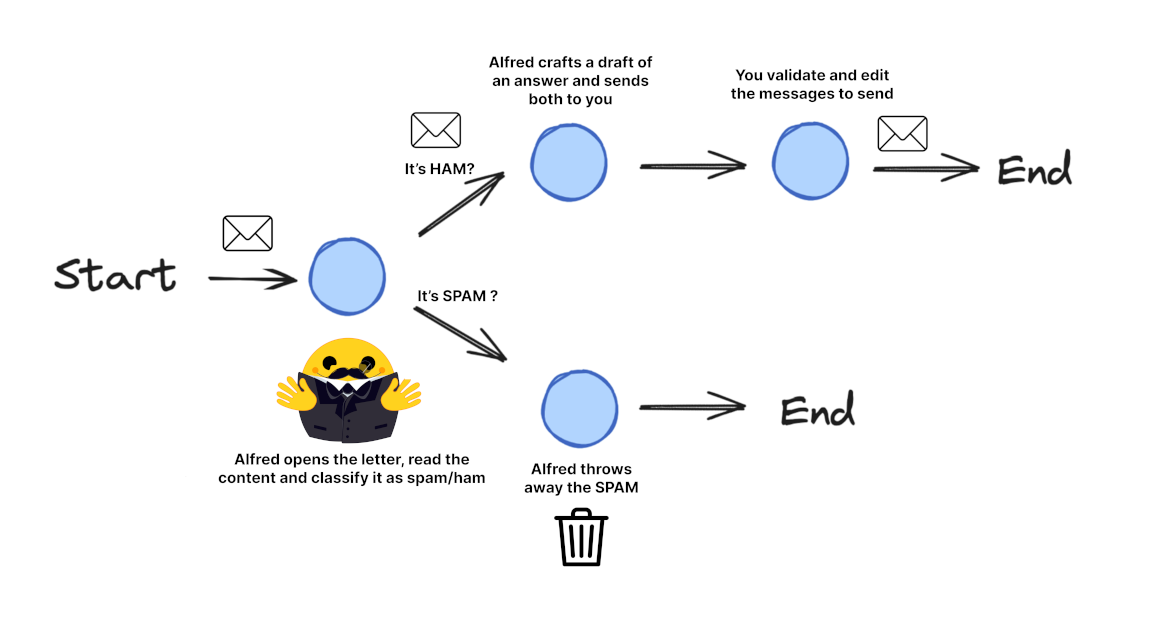

## Install Dependencies

In [1]:
%pip install -Uqq langgraph langchain_openai langchain_huggingface langchain-ollama

Note: you may need to restart the kernel to use updated packages.


In [14]:
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage

In [ ]:
# Initialize model
model = ChatOllama(model="qwen3:8b", temperature=0)

## Step 1: Define State
For Alfred's email processing system, we need to track:
- The email being processed
- Whether it's spam or not
- The draft response (for legitimate emails)
- Conversation history with the LLM

In [4]:
class EmailState(TypedDict): 
    email: Dict[str, Any]
    is_spam: Optional[bool]
    spam_reason: Optional[str]
    email_category: Optional[str]
    email_draft: Optional[str]
    messages: List[Dict[str, Any]]

## Step 2: Define Nodes

In [5]:
def read_email(state: EmailState): 
    email = state["email"]
    print(f"Alfred is processing and email from {email["sender"]} with subject {email["subject"]}.")
    return {}

In [56]:
import re

def classify_email_category(state: EmailState): 
    email = state["email"]
    prompt = f"""
    As Alfred the butler of Mr Wayne and it's SECRET identity Batman, analyze this email and determine if it is spam or legitimate and should be brought to Mr Wayne's attention.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    Classify the email with a single word. Only return the answer.
    Answer:
    """
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    response_text = response.content
    print(response_text)   
    
    pattern = r'<think>.*?</think>'
    result = re.sub(pattern, '', response_text, flags=re.DOTALL)

    return {"email_category": result.strip()}

In [ ]:
def classify_email(state: EmailState): 
    email = state["email"]
    prompt = f"""
    As Alfred the butler of Mr Wayne and it's SECRET identity Batman, analyze this email and determine if it is spam or legitimate and should be brought to Mr Wayne's attention.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    First, determine if this email is spam.
    Answer with SPAM or HAM if it's legitimate. Only return the answer.
    Answer:
    """
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    response_text = response.content.lower()
    print(response_text)

    is_spam = "spam" in response_text and "ham" not in response_text
    if not is_spam: 
        new_messages = state.get("messages", []) + [
            {"role": "user", "content": prompt}, 
            {"role": "assistant", "content": response.content}
        ]
    else: 
        new_messages = state.get("messages", [])

    return {
        "is_spam": is_spam, 
        "messages": new_messages
    }

In [7]:
def handle_spam(state: EmailState): 
    print(f"Alfred has marked the email as spam.")
    print("The email has been moved to the spam folder.")
    return {}

In [8]:
def drafting_response(state: EmailState): 
    email = state["email"]
    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    Draft a brief, professional response that Mr. Wayne can review and personalize before sending.
    """
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    return {
        "email_draft": response.content, 
        "messages": new_messages
    }

In [9]:
def notify_mr_wayne(state: EmailState): 
    email = state["email"]
    
    print("\n" + "=" * 50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print("\nI've prepared a draft response for your review:")
    print("-" * 50)
    print(state["email_draft"])
    print("=" * 50 + "\n")   

    return {} 

## Step 3: Define Routing Logic

> *💡 **Note**: This routing function is called by LangGraph to determine which edge to follow after the classification node. The return value must match one of the keys in our conditional edges mapping.*

In [ ]:
# Define routing logic for conditional edge
def route_email(state: EmailState) -> str: 
    if state["is_spam"]: 
        return "spam"
    else: 
        return "legitimate"

## Step 4: Create StateGraph and Define Edges

In [57]:
# Create graph
email_graph = StateGraph(EmailState)

In [58]:
# Add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email_category", classify_email_category)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam) 
email_graph.add_node("drafting_response", drafting_response)
email_graph.add_node("notify_mr_wayne", notify_mr_wayne)

In [59]:
# Add edges
email_graph.add_edge(START, "read_email")
email_graph.add_edge("read_email", "classify_email_category")
email_graph.add_edge("classify_email_category", "classify_email")
email_graph.add_conditional_edges(
    "classify_email", 
    route_email, 
    {   # Match with `route_email` return values
        "spam": "handle_spam", 
        "legitimate": "drafting_response"
    }
)

# Add final edges
email_graph.add_edge("handle_spam", END)

email_graph.add_edge("drafting_response", "notify_mr_wayne")
email_graph.add_edge("notify_mr_wayne", END)

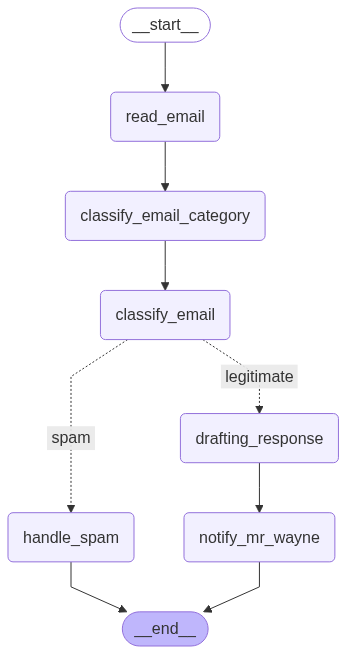

In [60]:
# Compile graph
compiled_graph = email_graph.compile()
compiled_graph

## Step 5: Run the Application

In [18]:
# Example legitimate email
legitimate_email = {
    "sender": "sarah.johnson@businesscorp.com",
    "subject": "Follow-up on recent meeting",
    "body": "Dear Ms. Thompson, I hope this email finds you well. I wanted to follow up on our meeting last week regarding the potential collaboration between our companies. Please let me know if there are any updates or if you need further information. Looking forward to your response. Best regards, Sarah Johnson"
}

# Example spam email
spam_email = {
    "sender": "urgent@bank-security.com",
    "subject": "URGENT: Your account has been compromised!",
    "body": "DEAR CUSTOMER, Your bank account has been accessed from an unknown device. To secure your account, please click the link below and verify your personal information immediately: [suspicious-link.com]. Failure to do so will result in account suspension."
}

In [19]:
# Process the legitimate email
print("[INFO] Processing legitimate email...")
legitimate_result = compiled_graph.invoke(
    {
        "email": legitimate_email, 
        "is_spam": None, 
        "spam_reason": None, 
        "email_category": None, 
        "email_draft": None, 
        "messages": []
    }
)

[INFO] Processing legitimate email...
Alfred is processing and email from sarah.johnson@businesscorp.com with subject Follow-up on recent meeting.
<think>
okay, let's see. the user wants me to act as alfred, batman's butler, analyzing an email to determine if it's spam or legitimate. the email is from sarah.johnson@businesscorp.com, subject is a follow-up on a recent meeting. the body mentions a potential collaboration between their companies and asks for updates or further info.

first, i need to check if this is spam. spam usually has suspicious elements like urgent requests, poor grammar, or attempts to trick the recipient. let me look at the email again. the sender is sarah johnson from businesscorp.com. the subject is a follow-up, which is common in legitimate emails. the body is polite and asks for updates, which is standard for a follow-up. there's no mention of money, attachments, or urgent action. the email seems to be a normal business communication. 

but wait, alfred is bat

In [20]:
legitimate_result

{'email': {'sender': 'sarah.johnson@businesscorp.com',
  'subject': 'Follow-up on recent meeting',
  'body': 'Dear Ms. Thompson, I hope this email finds you well. I wanted to follow up on our meeting last week regarding the potential collaboration between our companies. Please let me know if there are any updates or if you need further information. Looking forward to your response. Best regards, Sarah Johnson'},
 'is_spam': False,
 'spam_reason': None,
 'email_category': None,
 'email_draft': '<think>\nOkay, the user wants me to draft a polite preliminary response as Alfred the butler to Sarah Johnson\'s email. Let me start by understanding the context. The email is a follow-up from Sarah about a recent meeting discussing potential collaboration. The user is Mr. Wayne, who needs to review and personalize the response before sending.\n\nFirst, I need to make sure the response is professional and polite, reflecting Alfred\'s role as a butler. Since Alfred is the butler, the tone should b

In [22]:
legitimate_result.values()

dict_values([{'sender': 'sarah.johnson@businesscorp.com', 'subject': 'Follow-up on recent meeting', 'body': 'Dear Ms. Thompson, I hope this email finds you well. I wanted to follow up on our meeting last week regarding the potential collaboration between our companies. Please let me know if there are any updates or if you need further information. Looking forward to your response. Best regards, Sarah Johnson'}, False, None, None, '<think>\nOkay, the user wants me to draft a polite preliminary response as Alfred the butler to Sarah Johnson\'s email. Let me start by understanding the context. The email is a follow-up from Sarah about a recent meeting discussing potential collaboration. The user is Mr. Wayne, who needs to review and personalize the response before sending.\n\nFirst, I need to make sure the response is professional and polite, reflecting Alfred\'s role as a butler. Since Alfred is the butler, the tone should be formal but not overly stiff. The response should acknowledge S

In [23]:
# Process the spam email
print("processing spam email...")
span_result = compiled_graph.invoke(
    {
        "email": spam_email, 
        "is_spam": None, 
        "spam_reason": None,
        "email_category": None,
        "email_draft": None,
        "messages": []
    }
)

processing spam email...
Alfred is processing and email from urgent@bank-security.com with subject URGENT: Your account has been compromised!.
<think>
okay, let's see. the user wants me to act as alfred the butler for bruce wayne, aka batman. the task is to analyze an email and determine if it's spam or legitimate. the email is from urgent@bank-security.com with a subject about a compromised account. the body says they accessed the account from an unknown device and asks to click a link to verify info, threatening account suspension if not done.

first, i need to check if this is spam. the email has a suspicious domain, urgent@bank-security.com. wait, bruce wayne's bank is wayne enterprises, but maybe they have a security department. however, the email's domain is "bank-security.com" which sounds generic. legitimate banks usually have their own domains, like "bankofamerica.com" or similar. also, the link is suspicious-link.com, which is obviously a placeholder. the subject line is urge

In [24]:
span_result

{'email': {'sender': 'urgent@bank-security.com',
  'subject': 'URGENT: Your account has been compromised!',
  'body': 'DEAR CUSTOMER, Your bank account has been accessed from an unknown device. To secure your account, please click the link below and verify your personal information immediately: [suspicious-link.com]. Failure to do so will result in account suspension.'},
 'is_spam': True,
 'spam_reason': None,
 'email_category': None,
 'email_draft': None,
 'messages': []}

In [61]:
# Process the spam email
print("processing spam email...")
span_result = compiled_graph.invoke(
    {
        "email": spam_email, 
        "is_spam": None, 
        "spam_reason": None,
        "email_category": None,
        "email_draft": None,
        "messages": []
    }
)

processing spam email...
Alfred is processing and email from urgent@bank-security.com with subject URGENT: Your account has been compromised!.
<think>
Okay, let's see. The user wants me to act as Alfred the butler for Bruce Wayne, aka Batman. The task is to analyze an email and determine if it's spam or legitimate. The email is from urgent@bank-security.com with a subject about a compromised account. The body says they accessed the account from an unknown device and asks to click a link to verify info, threatening account suspension if not done.

First, I need to check for red flags. The email is from a generic email address, not a specific bank. The subject line is urgent, which is common in phishing emails. The link is suspicious-link.com, which doesn't look official. Also, the email is in all caps in the body, which is a sign of spam. Legitimate banks usually don't ask for personal info via links. The threat of account suspension is a common scare tactic. 

Since Alfred is the butle

In [62]:
span_result

{'email': {'sender': 'urgent@bank-security.com',
  'subject': 'URGENT: Your account has been compromised!',
  'body': 'DEAR CUSTOMER, Your bank account has been accessed from an unknown device. To secure your account, please click the link below and verify your personal information immediately: [suspicious-link.com]. Failure to do so will result in account suspension.'},
 'is_spam': True,
 'spam_reason': None,
 'email_category': 'spam',
 'email_draft': None,
 'messages': []}

In [63]:
# Process the legitimate email
print("[INFO] Processing legitimate email...")
legitimate_result = compiled_graph.invoke(
    {
        "email": legitimate_email, 
        "is_spam": None, 
        "spam_reason": None, 
        "email_category": None, 
        "email_draft": None, 
        "messages": []
    }
)

[INFO] Processing legitimate email...
Alfred is processing and email from sarah.johnson@businesscorp.com with subject Follow-up on recent meeting.
<think>
Okay, let's see. The user wants me to act as Alfred, the butler and secret identity of Batman, analyzing an email to determine if it's spam or legitimate. The email is from sarah.johnson@businesscorp.com, subject is a follow-up on a recent meeting. The body is addressed to Ms. Thompson, talking about a potential collaboration.

First, I need to check if the email is legitimate. The sender's email domain is businesscorp.com. But wait, the email is addressed to Ms. Thompson, but the sender's name is Sarah Johnson. Wait, the email is from Sarah Johnson, but the recipient is Ms. Thompson. Wait, the email is from Sarah Johnson to Ms. Thompson. But the user is Mr. Wayne, who is Batman. So, if the email is supposed to be from someone related to Wayne Enterprises, maybe the email is a phishing attempt?

Wait, the email is about a meeting reg

In [64]:
legitimate_result

{'email': {'sender': 'sarah.johnson@businesscorp.com',
  'subject': 'Follow-up on recent meeting',
  'body': 'Dear Ms. Thompson, I hope this email finds you well. I wanted to follow up on our meeting last week regarding the potential collaboration between our companies. Please let me know if there are any updates or if you need further information. Looking forward to your response. Best regards, Sarah Johnson'},
 'is_spam': False,
 'spam_reason': None,
 'email_category': 'legitimate',
 'email_draft': '<think>\nOkay, the user wants me to draft a polite preliminary response as Alfred the butler to Sarah Johnson\'s email. Let me start by understanding the context. The email is a follow-up from Sarah about a recent meeting discussing potential collaboration. The user is Mr. Wayne, who needs to review and personalize the response before sending.\n\nFirst, I need to make sure the response is professional and polite, reflecting Alfred\'s role as a butler. Since Alfred is the butler, the tone 

## Step 6: Inspecting Our Mail Sorting Agent with Langfuse 📡

In [65]:
# Set up API keys
import os

LANGFUSE_PUBLIC_KEY = os.environ["LANGFUSE_PUBLIC_KEY"]
LANGFUSE_SECRET_KEY = os.environ["LANGFUSE_SECRET_KEY"]
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"

In [66]:
from langfuse.callback import CallbackHandler

# Initialize `CallbackHandler` for tracing
langfuse_handler = CallbackHandler()

In [67]:
# Process legitimate email
print("Processing legitimate email...")
legitimate_result = compiled_graph.invoke(
    input={
        "email": legitimate_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []        
    }, 
    config={"callbacks": [langfuse_handler]}
)

Processing legitimate email...
Alfred is processing and email from sarah.johnson@businesscorp.com with subject Follow-up on recent meeting.
<think>
Okay, let's see. The user wants me to act as Alfred, the butler and secret identity of Batman, analyzing an email to determine if it's spam or legitimate. The email is from sarah.johnson@businesscorp.com, subject is a follow-up on a recent meeting. The body is addressed to Ms. Thompson, talking about a potential collaboration.

First, I need to check if the email is legitimate. The sender's email domain is businesscorp.com. But wait, the email is addressed to Ms. Thompson, but the sender's name is Sarah Johnson. Wait, the email is from Sarah Johnson, but the recipient is Ms. Thompson. Wait, the email is from Sarah Johnson to Ms. Thompson. But the user is Mr. Wayne, who is Batman. So, if the email is supposed to be from someone related to Wayne Enterprises, maybe the email is a phishing attempt?

Wait, the email is about a meeting regarding 

In [68]:
legitimate_result

{'email': {'sender': 'sarah.johnson@businesscorp.com',
  'subject': 'Follow-up on recent meeting',
  'body': 'Dear Ms. Thompson, I hope this email finds you well. I wanted to follow up on our meeting last week regarding the potential collaboration between our companies. Please let me know if there are any updates or if you need further information. Looking forward to your response. Best regards, Sarah Johnson'},
 'is_spam': False,
 'email_category': 'legitimate',
 'email_draft': '<think>\nOkay, the user wants me to draft a polite preliminary response as Alfred the butler to Sarah Johnson\'s email. Let me start by understanding the context. The email is a follow-up from Sarah about a recent meeting discussing potential collaboration. The user is Mr. Wayne, who needs to review and personalize the response before sending.\n\nFirst, I need to make sure the response is professional and polite, reflecting Alfred\'s role as a butler. Since Alfred is the butler, the tone should be formal but n

In [69]:
# Process spam email
print("Processing spam email")
spam_result = compiled_graph.invoke(
    input={
        "email": spam_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}    
)

Processing spam email
Alfred is processing and email from urgent@bank-security.com with subject URGENT: Your account has been compromised!.
<think>
Okay, let's see. The user wants me to act as Alfred the butler for Bruce Wayne, aka Batman. The task is to analyze an email and determine if it's spam or legitimate. The email is from urgent@bank-security.com with a subject about a compromised account. The body says they accessed the account from an unknown device and asks to click a link to verify info, threatening account suspension if not done.

First, I need to check for red flags. The email is from a generic email address, not a specific bank. The subject line is urgent, which is common in phishing emails. The link is suspicious-link.com, which doesn't look official. Also, the email is in all caps in the body, which is a sign of spam. Legitimate banks usually don't ask for personal info via links. The threat of account suspension is a common scare tactic. 

Since Alfred is the butler, 

In [70]:
spam_result

{'email': {'sender': 'urgent@bank-security.com',
  'subject': 'URGENT: Your account has been compromised!',
  'body': 'DEAR CUSTOMER, Your bank account has been accessed from an unknown device. To secure your account, please click the link below and verify your personal information immediately: [suspicious-link.com]. Failure to do so will result in account suspension.'},
 'is_spam': True,
 'email_category': 'spam',
 'messages': []}

**Trace for the legitimate email**
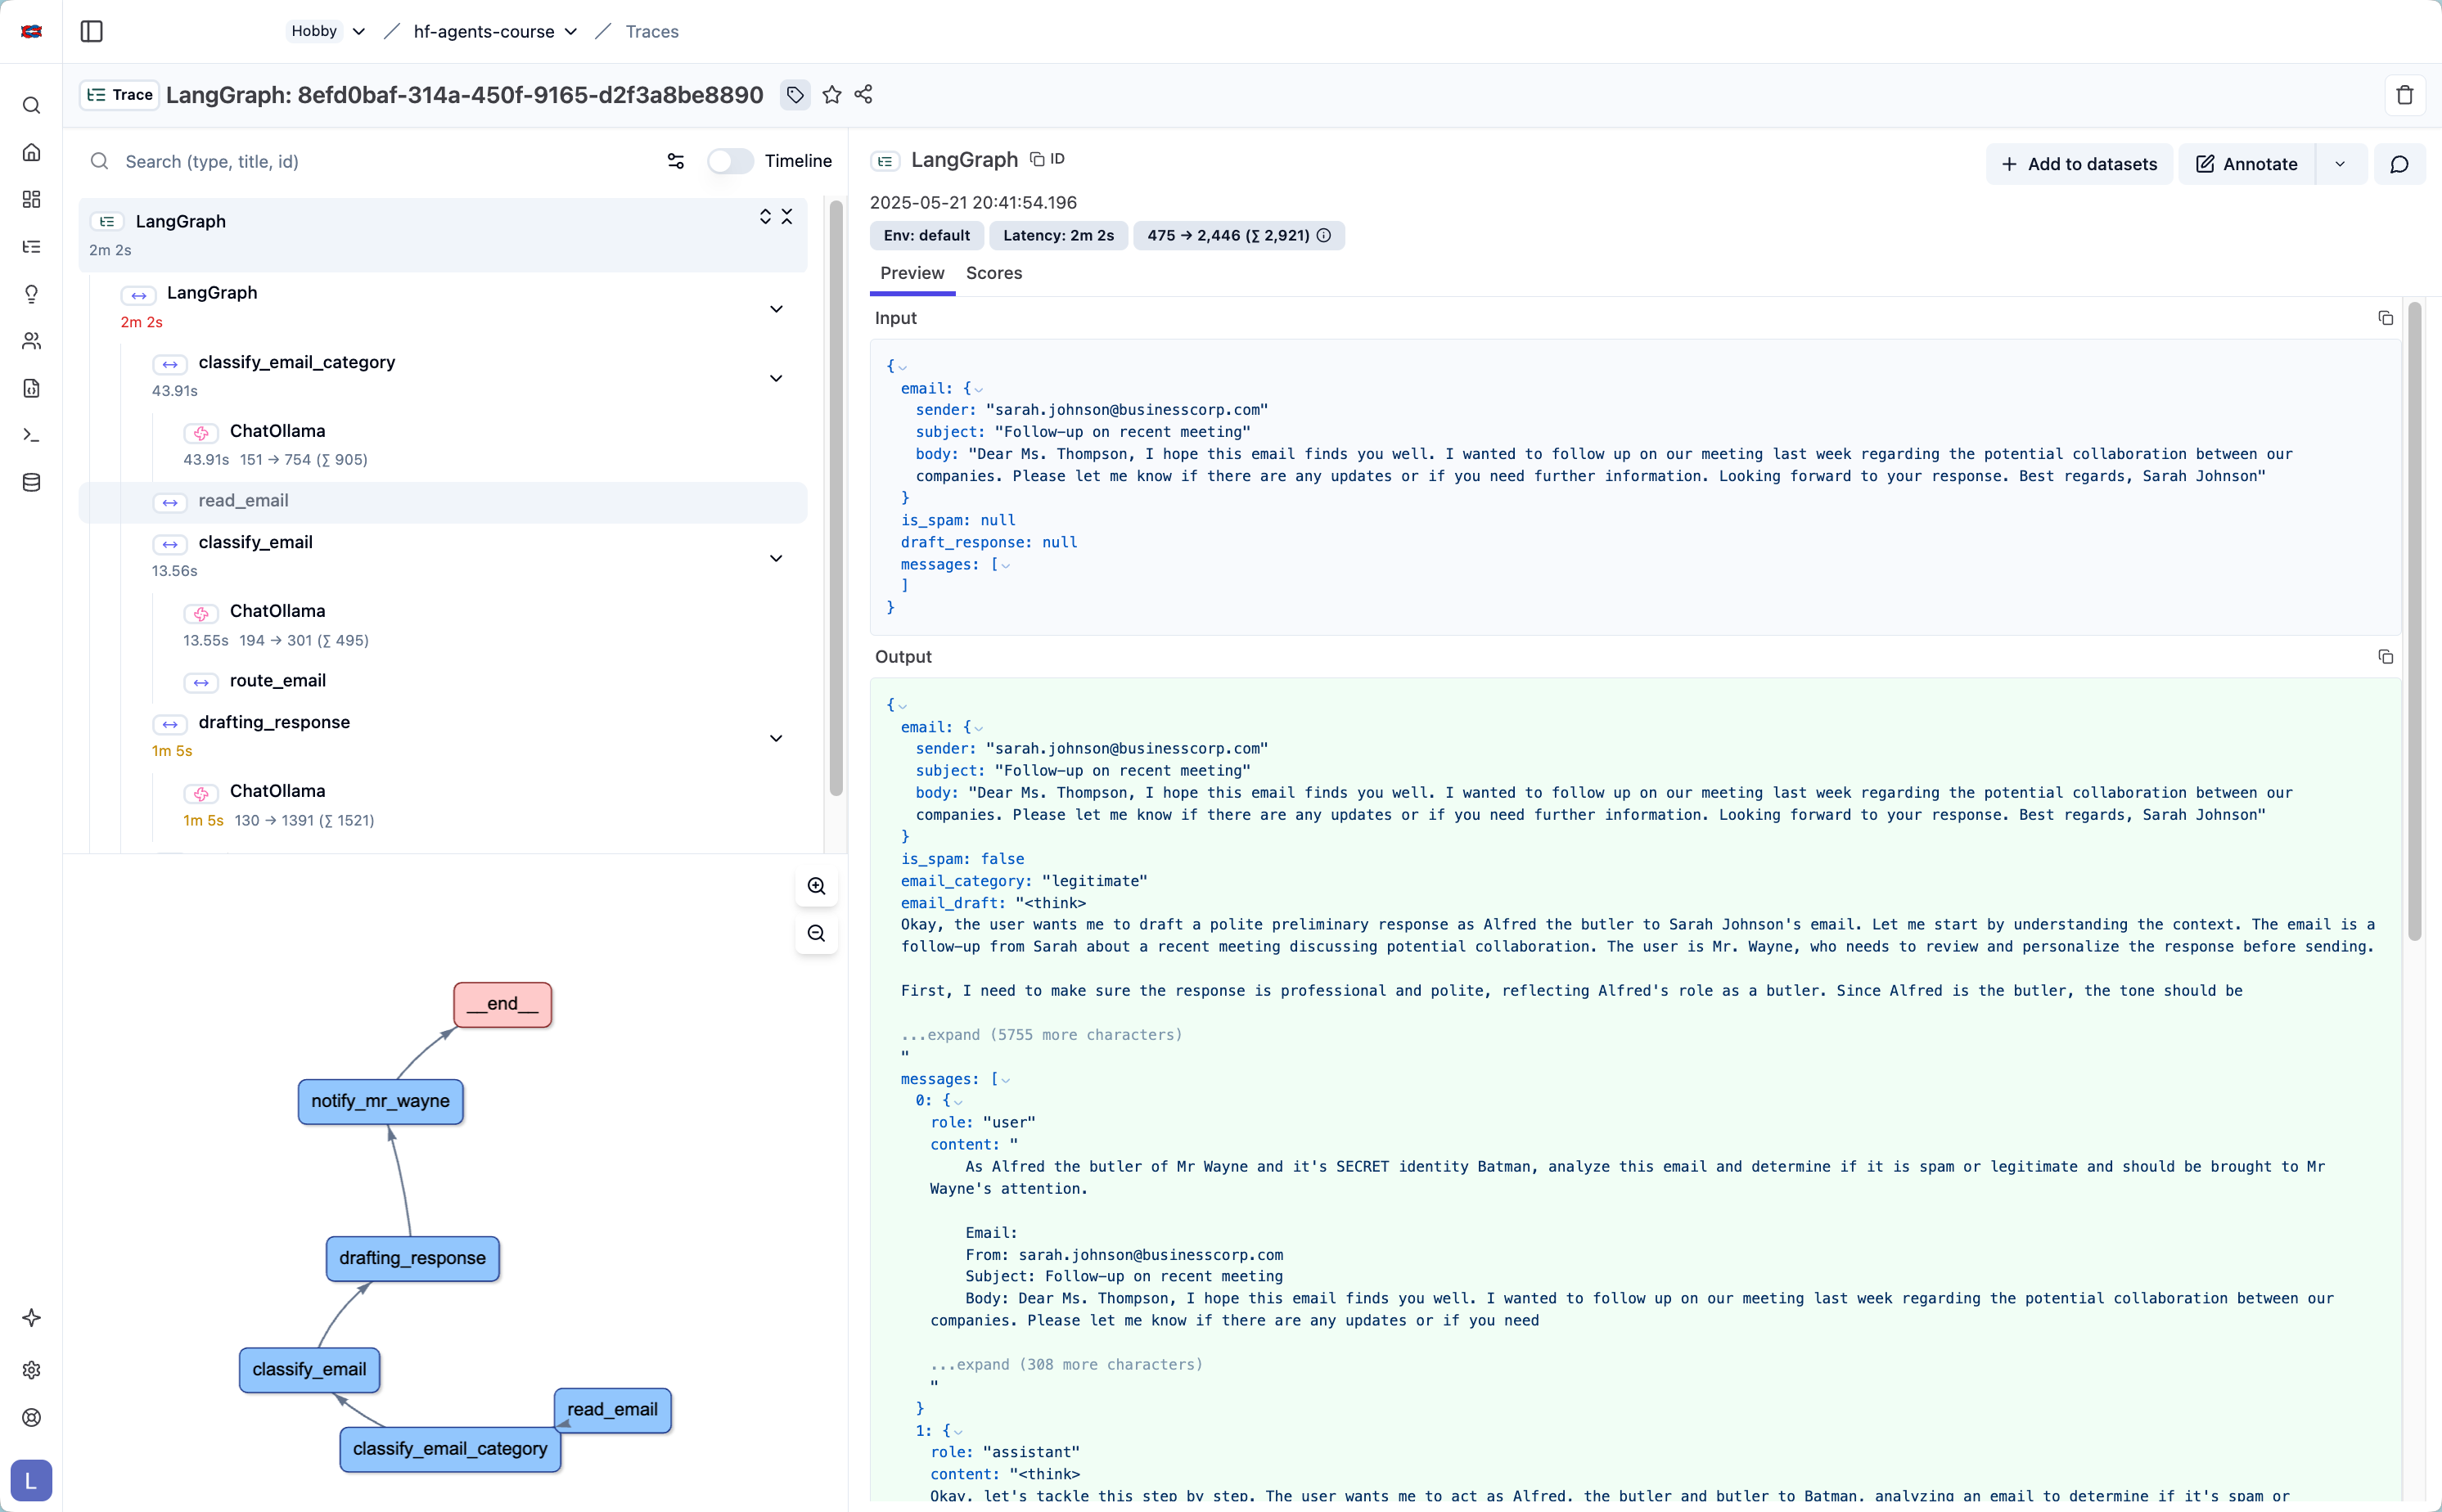

**Trace for the spam email**
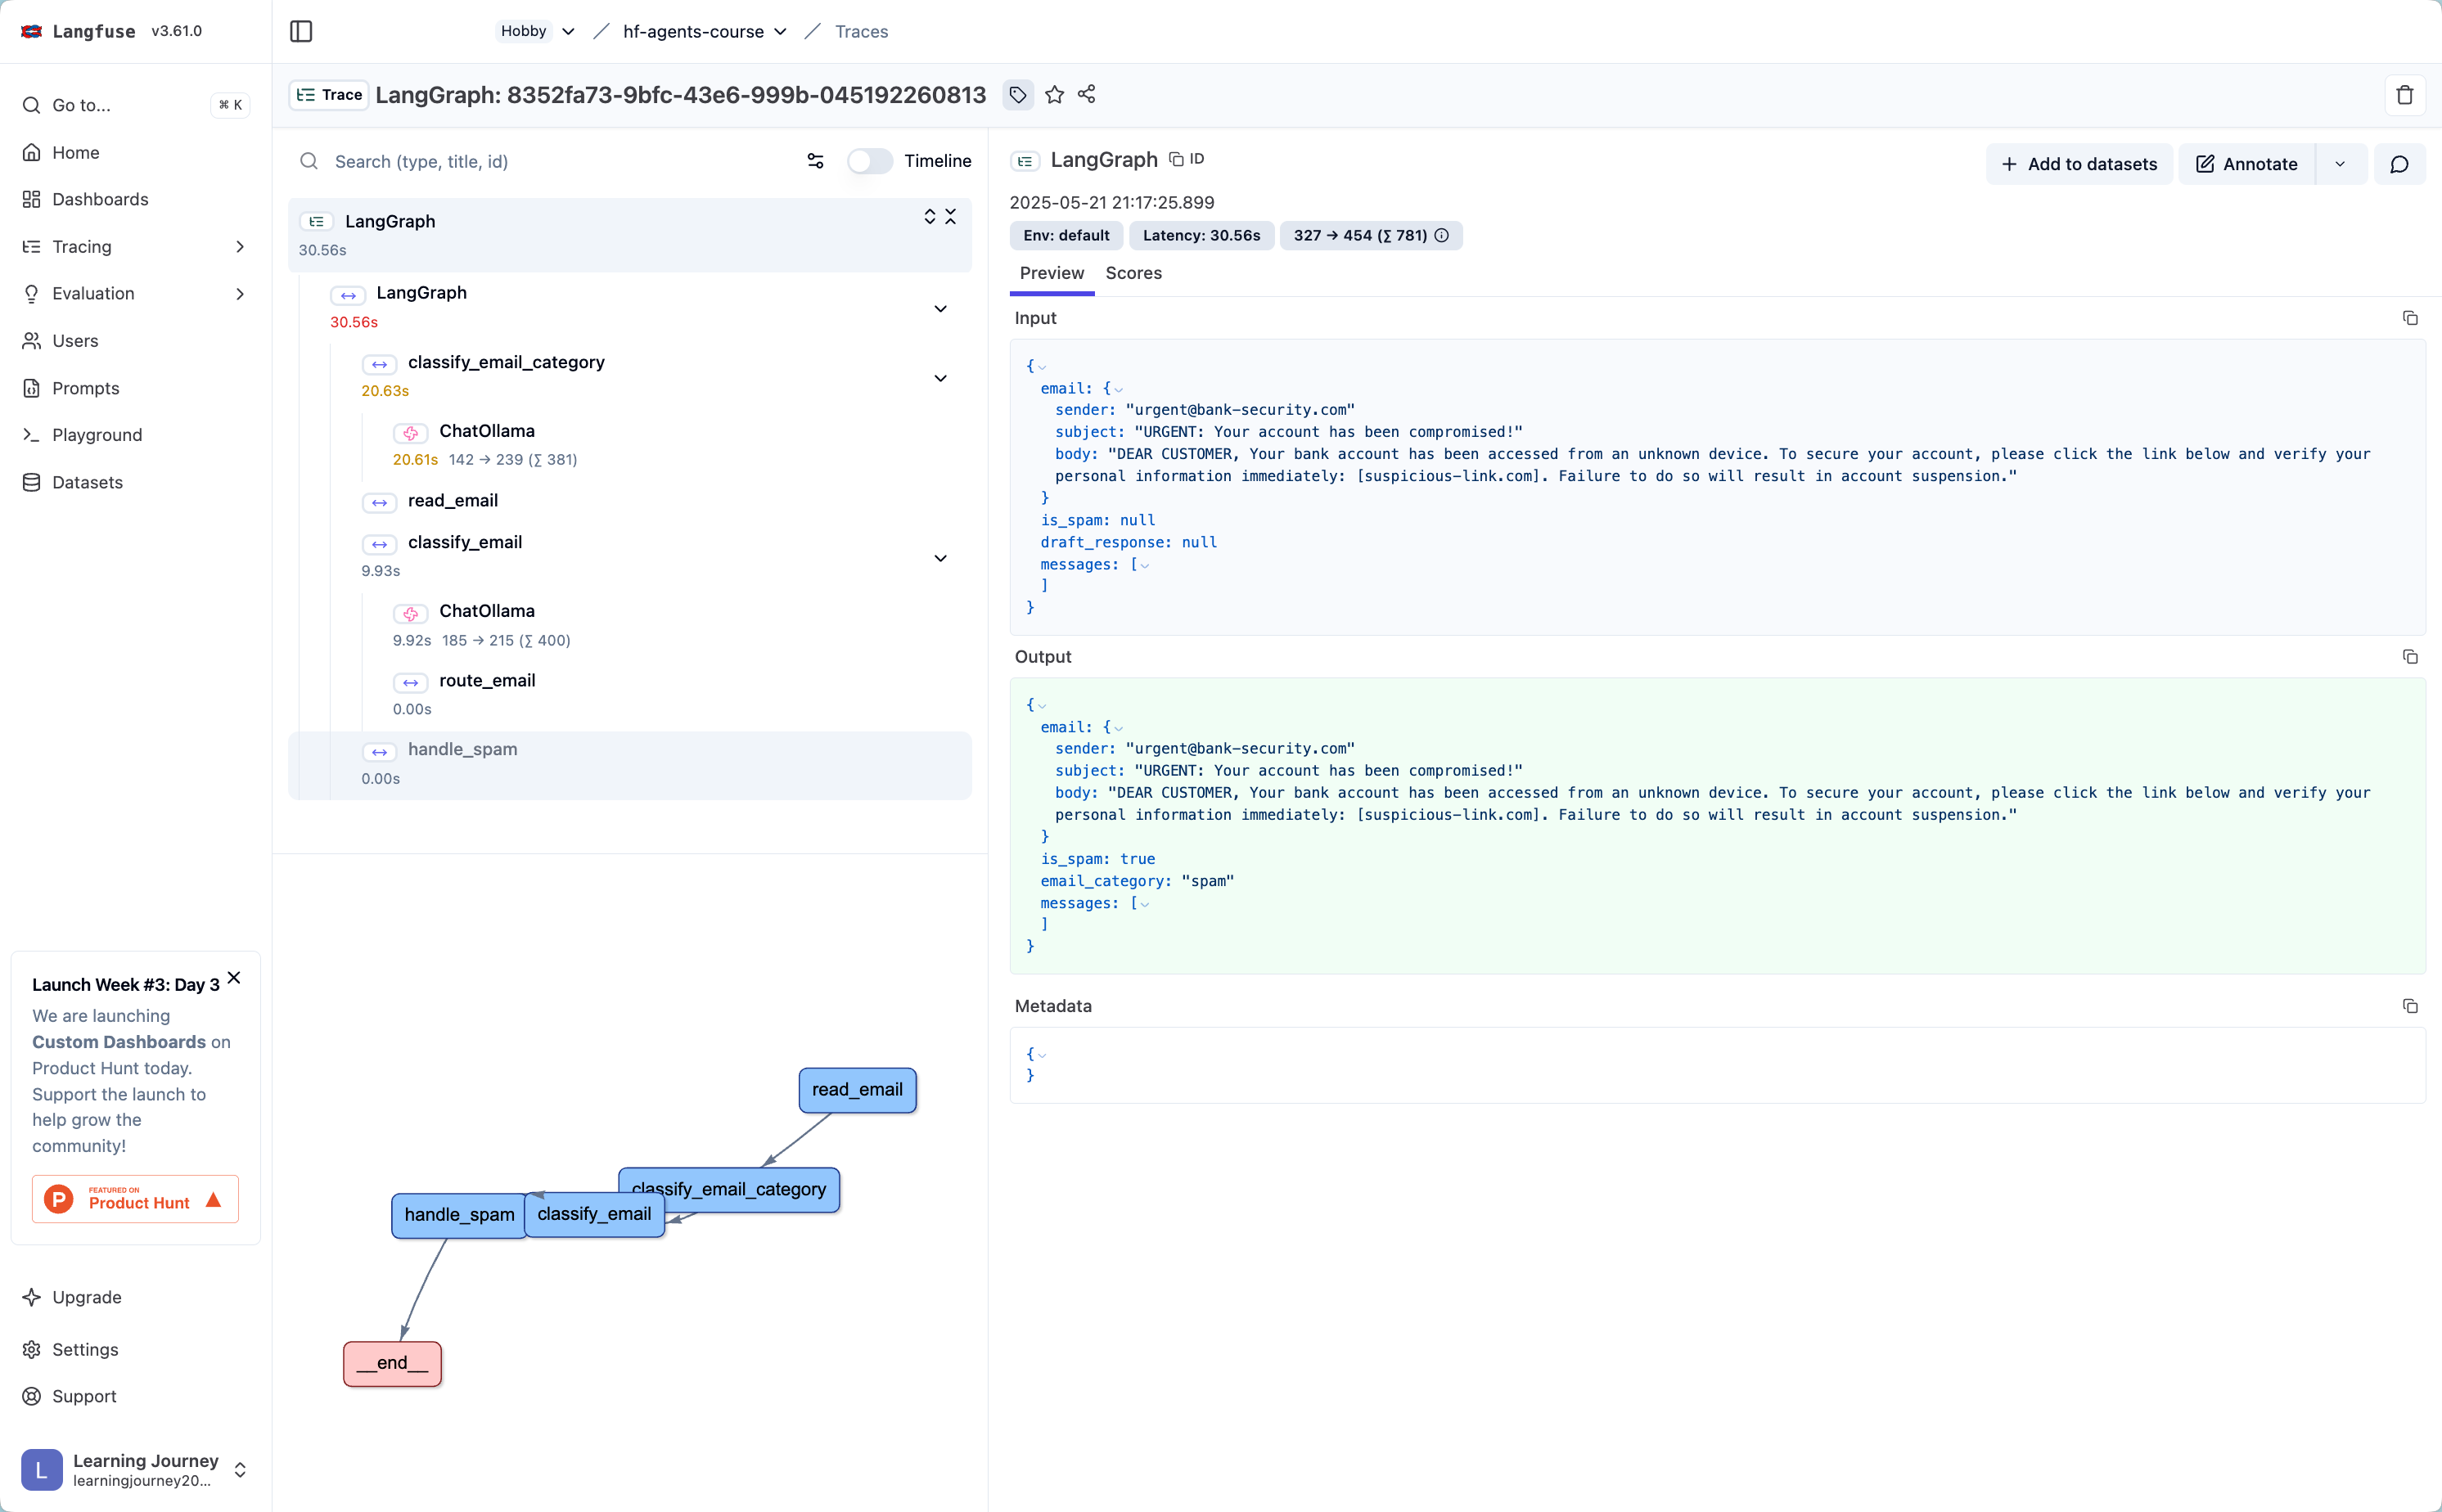